In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from helpers import parse_variables, get_risk_level, map_to_color
import warnings
from scipy.stats import t
from scipy import stats
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input, Model, layers, regularizers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

2024-06-27 16:03:32.551608: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 16:03:33.035506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 16:03:33.035651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 16:03:33.146643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 16:03:33.417773: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 16:03:33.423316: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def lin_reg(y, x, covariates=None):
    # Reshape x to have a single feature
    x = x.reshape(-1, 1)
    
    if covariates is not None:
        # Ensure covariates are 2D
        if len(covariates.shape) == 1:
            covariates = covariates.reshape(-1, 1)
        # Combine x and covariates
        X = np.hstack((x, covariates))
    else:
        X = x
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Extract coefficients
    intercept = model.intercept_
    betas = model.coef_
    
    # Coefficient of x (first feature)
    beta_x = betas[0]
    
    # Calculate residuals
    y_hat = model.predict(X)
    residuals = y - y_hat
    
    # Degrees of freedom
    n = len(y)
    k = X.shape[1]  # Number of predictors including covariates
    df_resid = n - k - 1  # n - (k + 1) because of the intercept
    
    # Residual standard error
    s_e = np.sqrt(np.sum(residuals**2) / df_resid)
    
    # Calculate standard error of the coefficient of x
    X_with_intercept = np.hstack((np.ones((n, 1)), X))
    XTX_inv = np.linalg.inv(X_with_intercept.T @ X_with_intercept)
    se_beta_x = s_e * np.sqrt(XTX_inv[1, 1])
    
    # Calculate t-value for the coefficient of x
    t_value_x = beta_x / se_beta_x
    
    # Calculate p-value for the coefficient of x
    p_value_x = (1 - t.cdf(np.abs(t_value_x), df_resid)) * 2
    
    # Return results specifically for x
    return intercept, beta_x, se_beta_x, t_value_x, p_value_x

In [3]:
def simulate_quant_trait(mu, genotypes, beta=0, env=0):
    mean = mu + np.dot(genotypes,beta) + env

    true_mean = sum(mean) / len(mean)
    mean = mean - true_mean
    trait = []
    for element in mean:
        trait.append(np.random.normal(element,1))
    return trait

In [4]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

In [5]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [6]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'NW_risk'

In [7]:
nr_common_PCs = 2
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 5
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]

In [8]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [9]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)

In [10]:
complete

snps,C0_AF_0.296425,C1_AF_0.21885,C2_AF_0.21275,C3_AF_0.2368,C4_AF_0.217525,C5_AF_0.20005,C6_AF_0.26035,C7_AF_0.3068,C8_AF_0.222275,C9_AF_0.296525,...,VR275_AF_0.0094,VR276_AF_0.00495,VR277_AF_0.0182,VR278_AF_0.008725,VR279_AF_0.003725,VR280_AF_0.016075,VR281_AF_0.0108,VR282_AF_0.008,VR283_AF_0.010525,VR284_AF_0.00345
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
complete["C0_AF_0.296425"].unique()

array([0. , 1. , 0.5])

In [12]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

In [13]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])

In [14]:
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk])))

# Create model

In [15]:
bottle_dims = pd.DataFrame()

In [16]:
# Sample data (replace with your actual data)
geno = complete * 2 - 1
pheno = risk
input_shape_geno = geno.shape[1]  # Fixed to be a single dimension
input_shape_pheno = pheno.shape
X_train, X_test = train_test_split(geno, test_size=0.2, random_state=42)

# Convert X_train and X_test to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Define the dimensions
n = geno.shape[1]
m = 1

# Initialize encoder weights
e1 = tf.Variable(tf.random.normal((n, m), mean=0.0, stddev=1.0), dtype=tf.float32)

# Initialize trainable constants array for encoder
c_e1 = tf.Variable(tf.random.normal((1, m), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)

# Initialize decoder weights
d1 = tf.Variable(tf.random.normal((m, n), mean=0.0, stddev=1.0), dtype=tf.float32)

# Initialize trainable constants array for decoder
c_d1 = tf.Variable(tf.random.normal((1, n), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)

# Define optimizer
optimizer = Adam(learning_rate=0.05)

# Define L2 regularization strength
lambda_reg = 0.001

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Binary crossentropy loss function
#loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.MeanSquaredError()
# Define batch size
batch_size = 64*64  # Example batch size, adjust as needed

# Training loop
for epoch in range(100):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        
        with tf.GradientTape() as tape:
            # Compute predictions for the current batch
            r_encoder_train = tf.matmul(X_batch, e1) + c_e1
            r_encoder_train = tf.nn.relu(r_encoder_train)

            r_decoder_train = tf.matmul(r_encoder_train, d1) + c_d1
            r_decoder_train = tf.keras.activations.sigmoid(r_decoder_train)

            # Compute mean squared error loss for the current batch
            loss = loss_fn(X_batch, r_decoder_train)

            # Compute L2 regularization loss
            l2_loss = lambda_reg * (tf.nn.l2_loss(e1) + tf.nn.l2_loss(d1))

            # Total loss
            train_loss = loss + l2_loss
        
        # Get gradients of e1, c_e1, d1, and c_d1
        gradients = tape.gradient(train_loss, [e1, c_e1, d1, c_d1])
        
        # Update e1, c_e1, d1, and c_d1 using optimizer
        optimizer.apply_gradients(zip(gradients, [e1, c_e1, d1, c_d1]))
    
    # After each epoch, compute and print test loss
    r_encoder_test = tf.matmul(X_test, e1) + c_e1
    r_encoder_test = tf.nn.relu(r_encoder_test)

    r_decoder_test = tf.matmul(r_encoder_test, d1) + c_d1
    r_decoder_test = tf.keras.activations.linear(r_decoder_test)

    test_loss = loss_fn(X_test, r_decoder_test)
    l2_test_loss = lambda_reg * (tf.nn.l2_loss(e1) + tf.nn.l2_loss(d1))
    test_loss = test_loss + l2_test_loss
    
    # Store the losses
    train_losses.append(train_loss.numpy())
    test_losses.append(test_loss.numpy())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss.numpy()}, Test Loss: {test_loss.numpy()}')

# Function to get encoder output
def get_encoder_output(input_data, e1, c_e1):
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    encoder_output = tf.matmul(input_data, e1) + c_e1
    encoder_output = tf.nn.relu(encoder_output)
    return encoder_output

# Get the encoder output for geno
encoder_output_geno = get_encoder_output(geno, e1, c_e1)
print("Encoder output for geno:\n", encoder_output_geno.numpy())

# Optionally, return the history of training and test losses
history = {
    'train_loss': train_losses,
    'test_loss': test_losses
}

Epoch 0, Train Loss: 1.2694118022918701, Test Loss: 2.384422540664673
Epoch 10, Train Loss: 0.4212821125984192, Test Loss: 0.9834218621253967
Epoch 20, Train Loss: 0.3867258131504059, Test Loss: 1.2908999919891357
Epoch 30, Train Loss: 0.34760913252830505, Test Loss: 2.7472426891326904
Epoch 40, Train Loss: 0.34447091817855835, Test Loss: 3.091946601867676
Epoch 50, Train Loss: 0.34358954429626465, Test Loss: 3.2793402671813965
Epoch 60, Train Loss: 0.34315407276153564, Test Loss: 3.419501304626465
Epoch 70, Train Loss: 0.34293147921562195, Test Loss: 3.635427951812744
Epoch 80, Train Loss: 0.34309038519859314, Test Loss: 3.580383539199829
Epoch 90, Train Loss: 0.3430347740650177, Test Loss: 3.876070022583008
Encoder output for geno:
 [[15.1460285]
 [15.290801 ]
 [15.133383 ]
 ...
 [25.74259  ]
 [25.615488 ]
 [26.030321 ]]


In [17]:
bottle_dims['dim1'] = encoder_output_geno.numpy().flatten()

In [18]:
bottle_dims

,dim1
0,15.146029
1,15.290801
2,15.133383
3,15.194806
4,15.133383
...,...
19995,25.922403
19996,26.030321
19997,25.742590
19998,25.615488


In [19]:
# Load populations
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_dims[to_have_collumns] = populations[to_have_collumns]

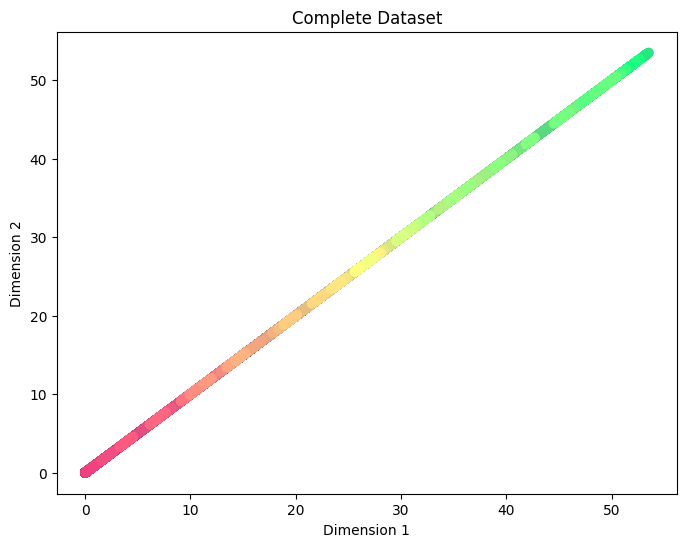

In [20]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_dims['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_dims) for x, y, z in zip(bottle_dims['x'], bottle_dims['y'], bottle_dims['z'])]
plt.scatter(x=bottle_dims['dim1'], y=bottle_dims['dim1'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

# Second dimension

In [21]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the dimensions
n = geno.shape[1]
m = 1

# Convert geno to float32
geno_tensor = tf.convert_to_tensor(geno, dtype=tf.float32)

# Initialize encoder weights
e2 = tf.Variable(tf.random.normal((n, m), mean=0.0, stddev=1.0), dtype=tf.float32)

# Initialize trainable constants array for encoder
c_e2 = tf.Variable(tf.random.normal((n, m), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)

# Initialize decoder weights
d2 = tf.Variable(tf.random.normal((m, n), mean=0.0, stddev=1.0), dtype=tf.float32)

# Initialize trainable constants array for decoder
c_d2 = tf.Variable(tf.random.normal((n, n), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)

# Create new encoder and decoder weights by concatenation
new_e1 = tf.Variable(e1, trainable=False, dtype=tf.float32)
e12 = tf.concat([new_e1, e2], axis=1)

new_ce1 = tf.Variable(c_e1, trainable=False, dtype=tf.float32)
c_e2 = tf.Variable(tf.random.normal((1, m), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)
c_e12 = tf.concat([new_ce1, c_e2], axis=1)

new_d1 = tf.Variable(d1, trainable=False, dtype=tf.float32)
d12 = tf.concat([new_d1, d2], axis=0)

new_cd1 = tf.Variable(c_d1, trainable=False, dtype=tf.float32)
c_d2 = tf.Variable(tf.random.normal((1, n), mean=0.0, stddev=1.0), trainable=True, dtype=tf.float32)
c_d12 = c_d2

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Define L2 regularization strength
lambda_reg = 0.001

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Mean squared error loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Define batch size
batch_size = 64  # Adjusted batch size for lower memory usage

@tf.function
def train_step(X_batch):
    with tf.GradientTape() as tape:
        # Compute predictions for the current batch
        r_encoder_train = tf.matmul(X_batch, e12) + c_e12
        r_encoder_train = tf.nn.relu(r_encoder_train)

        r_decoder_train = tf.matmul(r_encoder_train, d12) + c_d12
        r_decoder_train = tf.keras.activations.sigmoid(r_decoder_train)

        # Compute mean squared error loss for the current batch
        loss = loss_fn(X_batch, r_decoder_train)

        # Compute L2 regularization loss
        l2_loss = lambda_reg * (tf.nn.l2_loss(e12) + tf.nn.l2_loss(d12))

        # Total loss
        train_loss = loss + l2_loss
    
    # Get gradients of e12, c_e12, d12, and c_d12
    gradients = tape.gradient(train_loss, [e12, c_e12, d12, c_d12])
    
    # Filter out None gradients to avoid errors
    grads_and_vars = [(g, v) for g, v in zip(gradients, [e12, c_e12, d12, c_d12]) if g is not None]
    
    # Update e12, c_e12, d12, and c_d12 using optimizer
    optimizer.apply_gradients(grads_and_vars)
    
    return train_loss

@tf.function
def test_step(X_test):
    r_encoder_test = tf.matmul(X_test, e12) + c_e12
    r_encoder_test = tf.nn.relu(r_encoder_test)

    r_decoder_test = tf.matmul(r_encoder_test, d12) + c_d12
    r_decoder_test = tf.keras.activations.linear(r_decoder_test)

    test_loss = loss_fn(X_test, r_decoder_test)
    l2_test_loss = lambda_reg * (tf.nn.l2_loss(e12) + tf.nn.l2_loss(d12))
    test_loss = test_loss + l2_test_loss
    return test_loss

# Training loop
for epoch in range(350):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        
        train_loss = train_step(X_batch)
    
    test_loss = test_step(X_test)
    
    # Store the losses
    train_losses.append(train_loss.numpy())
    test_losses.append(test_loss.numpy())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss.numpy()}, Test Loss: {test_loss.numpy()}')

# Function to get encoder output
@tf.function
def get_encoder_output(input_data, e1, c_e1):
    encoder_output = tf.matmul(input_data, e1) + c_e1
    encoder_output = tf.nn.relu(encoder_output)
    return encoder_output

# Get the encoder output for geno
encoder_output_geno = get_encoder_output(geno_tensor, e12, c_e12)

# Optionally, return the history of training and test losses
history = {
    'train_loss': train_losses,
    'test_loss': test_losses
}


Epoch 0, Train Loss: 1.4106922149658203, Test Loss: 158.860595703125
Epoch 10, Train Loss: 1.3059561252593994, Test Loss: 153.9125518798828
Epoch 20, Train Loss: 1.280731439590454, Test Loss: 152.36160278320312
Epoch 30, Train Loss: 1.269864797592163, Test Loss: 152.0458984375
Epoch 40, Train Loss: 1.262082576751709, Test Loss: 152.80702209472656
Epoch 50, Train Loss: 1.2559746503829956, Test Loss: 154.7078399658203
Epoch 60, Train Loss: 1.250844955444336, Test Loss: 157.7642364501953
Epoch 70, Train Loss: 1.2465962171554565, Test Loss: 161.89566040039062
Epoch 80, Train Loss: 1.243274211883545, Test Loss: 167.0130157470703
Epoch 90, Train Loss: 1.2406774759292603, Test Loss: 173.04580688476562
Epoch 100, Train Loss: 1.2385839223861694, Test Loss: 179.93148803710938
Epoch 110, Train Loss: 1.2369883060455322, Test Loss: 187.56167602539062
Epoch 120, Train Loss: 1.2356070280075073, Test Loss: 195.8001708984375
Epoch 130, Train Loss: 1.2344493865966797, Test Loss: 204.52792358398438
Epoch

In [22]:
bottle_dims['dim1'] = encoder_output_geno.numpy()[:,0]
bottle_dims['dim2'] = encoder_output_geno.numpy()[:,1]

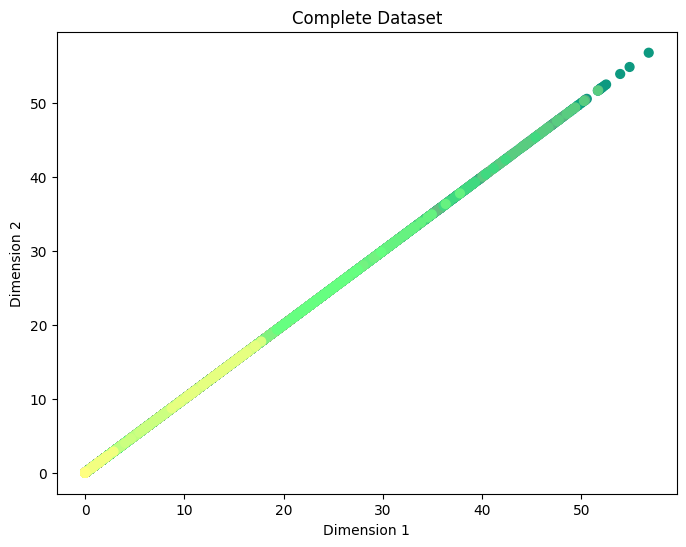

In [24]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_dims['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_dims) for x, y, z in zip(bottle_dims['x'], bottle_dims['y'], bottle_dims['z'])]
plt.scatter(x=bottle_dims['dim1'], y=bottle_dims['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()